# FML Capstone Project
Richard Zhu, rz2123

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.notebook import tqdm

random.seed(16391561)
sns.set()

warnings.filterwarnings('ignore')

## Data manipulation

### Data loading

In [2]:
movie_titles_df = pd.read_csv("./dataSet/movieTitles.csv", header=None)
movie_titles_df.drop(columns=[3, 4], inplace=True)
movie_titles_df.dropna(axis=0, how='any', inplace=True)
movie_titles_df.columns = ["movie_id", "release_date", "movie_title"]
movie_titles_df.set_index("movie_id", inplace=True)
movie_titles_df

,release_date,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
4996,2000.0,Gone in 60 Seconds
4997,2004.0,Alabama Love Story
4998,1948.0,Anna Karenina


In [3]:
with open("./dataSet/data.txt") as f:
    data = f.readlines()
    
data = [line.strip() for line in tqdm(data, desc="Strip new line chars")]

pattern = r"^\d+:$"
flat_data = []
for line in tqdm(data, desc="Split data by colon"):
    if re.match(pattern, line):
        curr_movie_id = line.split(":")[0]
    else:
        flat_data.append([curr_movie_id] + line.split(','))
        
data_df = pd.DataFrame(flat_data, columns=['movie_id', 'customer_id', 'rating', 'rating_date'])
data_df['movie_id'] = data_df['movie_id'].astype(int)
data_df['customer_id'] = data_df['customer_id'].astype(int)
data_df['rating'] = data_df['rating'].astype(int)
data_df['rating_date'] = pd.to_datetime(data_df['rating_date'])
data_df

Strip new line chars:   0%|          | 0/27015225 [00:00<?, ?it/s]

Split data by colon:   0%|          | 0/27015225 [00:00<?, ?it/s]

,movie_id,customer_id,rating,rating_date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
27010220,5000,2415316,3,2004-01-28
27010221,5000,1619362,3,2005-01-12
27010222,5000,453585,4,2005-03-28
27010223,5000,477466,3,2005-10-17


### Data visualization

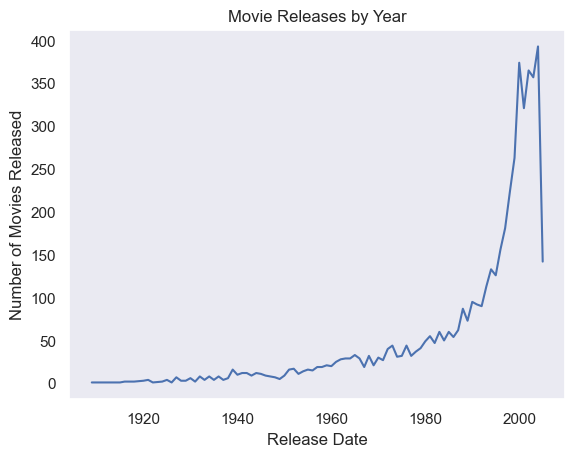

In [4]:
movie_counts = movie_titles_df.groupby('release_date').size()
plt.plot(movie_counts.index, movie_counts.values)
plt.xlabel('Release Date')
plt.ylabel('Number of Movies Released')
plt.title('Movie Releases by Year')
plt.grid()
plt.show()

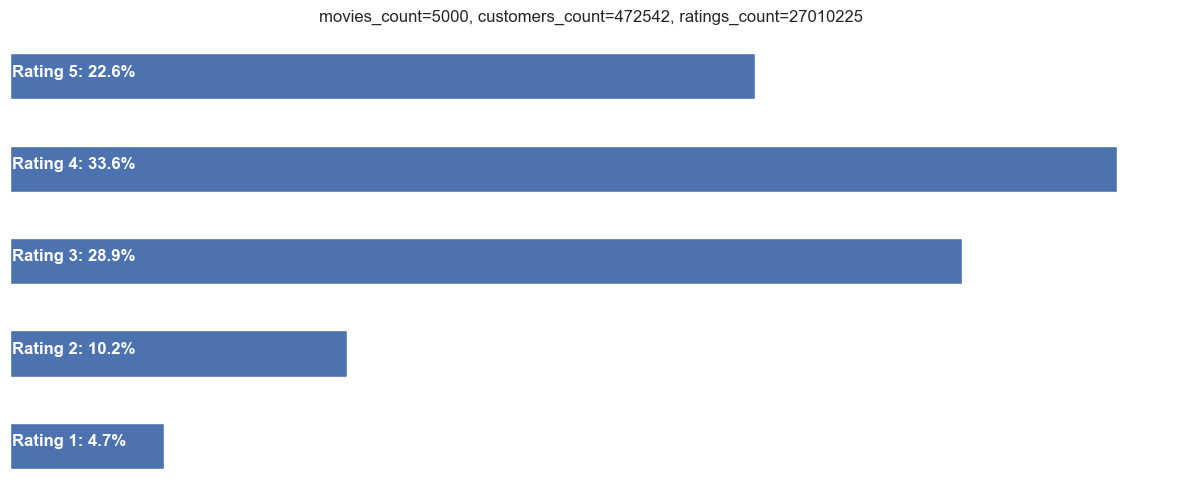

In [5]:
rating_counts = data_df.groupby('rating')['rating'].agg(['count'])

movies_count = len(data_df.movie_id.unique())
customers_count = len(data_df.customer_id.unique())
ratings_count = len(data_df)

ax = rating_counts.plot(kind='barh', legend=False, figsize=(15, 6))
plt.title(f"{movies_count=}, {customers_count=}, {ratings_count=}")

for i in range(1,6):
    percentage = rating_counts.iloc[i-1][0] / rating_counts.sum()[0] * 100
    ax.text(20000, i-1, f'Rating {i}: {round(percentage, 1)}%', color='white', weight='bold')

plt.axis('off')
plt.show()

### Data cleaning

In [6]:
# Merge dfs
result_df = data_df.merge(movie_titles_df, on='movie_id', how='left')

# Mean imputation for release date
result_df['release_date'].fillna(value=result_df['release_date'].mean(), inplace=True)

# Add days since release
result_df['days_since_release'] = (result_df['rating_date'] - pd.to_datetime(result_df['release_date'], format='%Y')).dt.days

# Remove rating date and movie title
result_df.drop(['rating_date', 'movie_title'], axis=1, inplace=True)

# Standardize movie_id and customer_id
cols_to_scale = ['movie_id', 'customer_id', 'release_date', 'days_since_release']
scalar = StandardScaler()
scaled_cols = scalar.fit_transform(result_df[cols_to_scale])
result_df[cols_to_scale] = scaled_cols

result_df

,movie_id,customer_id,rating,release_date,days_since_release
0,-1.776593,0.217883,3,0.694841,-0.623399
1,-1.776593,-0.654147,5,0.694841,-0.648842
2,-1.776593,-0.571874,4,0.694841,-0.613968
3,-1.776593,-1.689006,4,0.694841,-0.599053
4,-1.776593,-0.652302,3,0.694841,-0.731092
...,...,...,...,...,...
27010220,1.671701,1.429626,3,-0.025257,-0.031194
27010221,1.671701,0.388589,3,-0.025257,0.045573
27010222,1.671701,-1.136143,4,-0.025257,0.062023
27010223,1.671701,-1.104909,3,-0.025257,0.106548


### Data splitting

In [7]:
test_idxs = []
for idx, (movie_id, tdf) in enumerate(result_df.groupby("movie_id")):
    test_idxs.append(random.randint(tdf.index.min(), tdf.index.max()))

In [8]:
train_df = result_df.drop(test_idxs, axis=0)
test_df = result_df[result_df.index.isin(test_idxs)]
X_train, y_train = train_df.drop(['rating'], axis=1).values, train_df.rating.values
X_test, y_test = test_df.drop(['rating'], axis=1).values, test_df.rating.values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27005225, 4) (27005225,)
(5000, 4) (5000,)


In [9]:
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.fit_transform(y_test.reshape(-1, 1))

print(y_train.shape, y_test.shape)

(27005225, 5) (5000, 5)


### Creating data loaders

In [10]:
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [11]:
batch_size = 64

train_dataset = MovieDataset(X_train, y_train)
valid_dataset = MovieDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Models

### RNN

In [13]:
epochs = 3
learning_rate = 0.001
cost = nn.MSELoss()

input_size = len(X_train[0])
hidden_size = 16
output_size = 5

device = torch.device("cpu:0")

def train_model(model, train_loader, cost, optimizer, valid_loader, device):
    model = model.to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss, train_rmse = train_epoch(model, train_loader, cost, optimizer, device)

        model.eval()
        with torch.no_grad():
            valid_loss, valid_rmse = valid_epoch(model, valid_loader, device)
            
        print(f"{train_loss=}, {valid_loss=}, {train_rmse=}, {valid_rmse=}")
        
def train_epoch(model, train_loader, cost, optimizer, device):
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for i, (inputs, labels) in enumerate(tqdm_object):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = cost(outputs, labels.float().to(device))
        loss.requires_grad_()
        loss.backward()
        optimizer.step()
        
        rmse = mean_squared_error(labels, outputs.detach().numpy(), squared=False)
        if i % 1000 == 0:
            tqdm_object.set_postfix(train_loss=loss.detach().numpy())
    return float(loss.detach().numpy()), rmse

def valid_epoch(model, valid_loader, device):
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for inputs, labels in tqdm_object:
        outputs = model(inputs.to(device))
        loss = cost(outputs, labels.float())
        
        rmse = mean_squared_error(labels, outputs.detach().numpy(), squared=False)
        tqdm_object.set_postfix(test_loss=loss.numpy())
    return float(loss.numpy()), rmse

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.rnn(x.unsqueeze(1), h0)
        x = self.fc(x[:, -1, :])
        x = torch.tanh(x)
        return x
    
rnn = RNN(input_size, hidden_size, output_size, 1, 0.2)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
train_model(rnn, train_loader, cost, optimizer, valid_loader, device)

Epoch: 1


  0%|          | 0/421957 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train_loss=0.1500975340604782, valid_loss=0.15014967322349548, train_rmse=0.3759851567216993, valid_rmse=0.3638244623535146
Epoch: 2


  0%|          | 0/421957 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train_loss=0.14017726480960846, valid_loss=0.15105409920215607, train_rmse=0.33859187608682423, valid_rmse=0.3659243840011466
Epoch: 3


  0%|          | 0/421957 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train_loss=0.15614567697048187, valid_loss=0.1510317027568817, train_rmse=0.39033076218321994, valid_rmse=0.365462104700332
